In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from PIL import Image
img = Image.open(r'/kaggle/input/oral-cancer-dataset/Oral Cancer5/train/Normal/Normal_100x_1.jpg')
img.size

(2048, 1536)

In [1]:
pip install thop

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn.functional import cross_entropy
import os
from thop import profile
import pandas as pd
import glob
import math
import torch.optim.lr_scheduler as lr_scheduler
import sys

# 配置运行设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 设置参数
batch_size = 32
learning_rate = 0.00003
num_epoch = 70
model_name = 'basenet'

In [3]:
torch.__version__

'1.11.0'

In [4]:
for i in glob.glob('/kaggle/working/check_point/capsnet_v2' + '/*'):
    print(i)
    os.remove(i)

In [5]:
for i in glob.glob('/kaggle/working/check_point/capsnet_v2' + '/*'):
    print(i)

In [4]:
# 数据处理
normalize = transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    normalize
])

# 读取图像数据
train_dataset = ImageFolder('/kaggle/input/oral-cancer-dataset/Oral Cancer5/train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ImageFolder('/kaggle/input/oral-cancer-dataset/Oral Cancer5/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('{0} for train. {1} for val'.format(len(train_dataset), len(test_dataset)))

1680 for train. 188 for val


In [5]:
device

device(type='cuda')

In [6]:
class Basenet(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        input_shape: [B, 3, 224, 224]

        '''
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_layer1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
        self.conv_layer2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv_layer4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_layer5 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_layer6 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.inception = nn.Conv2d(32, 128, 3, stride=1, padding=1)
        self.conv_layer_res = nn.Conv2d(128, 128, 3, stride=1, padding=1)

        
        self.relu = nn.ReLU(inplace=True)
        self.adptavgpool2d = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, 2, bias=True)
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

    def forward(self, x):
        """
        args:
            x: Input img, (B, 3, 224, 224)
        return:
            the calss capsules, ench capsule is a 16 dimension vector

        """
        x = self.relu(self.conv_layer1(x))  # [B, 16, 224, 224]
        x = self.maxpool(x)# [B, 16, 112, 112]
        x = self.relu(self.conv_layer2(x))
        y = self.maxpool(x)# [B, 32, 56, 56]
        
        
        x = self.relu(self.conv_layer3(y))
        x = self.maxpool(x) # [B, 64, 28, 28]
        x = self.conv_layer4(x) # [B, 128, 28, 28]
        
        y = self.inception(y) # [B, 128, 56, 56]
        y = self.maxpool(self.conv_layer_res(y)) # [B, 128, 28, 28]
        
        x = self.relu(x + y)
        x = self.maxpool(x) # [B, 128, 14, 14]
        x = self.relu(self.conv_layer5(x)) # [B, 256, 14, 14]
        x = self.maxpool(x)
        x = self.relu(self.conv_layer6(x)) # [B, 512, 7, 7]
        
        x = self.adptavgpool2d(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [8]:
save_path = '/kaggle/working/check_point'
if not os.path.exists(save_path):
    os.mkdir(save_path)
result_path = os.path.join('/kaggle/working/check_point', model_name)
if not os.path.exists(result_path):
    print(1)
    os.mkdir(result_path)
if len(glob.glob(result_path + '/**.pth')) == 0:
    model = Basenet()
    fc_in_features = model.fc.in_features
    model.fc = torch.nn.Linear(fc_in_features, 2, bias=True)
else:
    model_path = glob.glob(result_path + '/**.pth')[-1]
    model = torch.load(model_path)
    

train_test_data_path = os.path.join(result_path, 'train_test_data.csv')
if os.path.exists(train_test_data_path):
    train_test_data = pd.read_csv(train_test_data_path)
    last_epoch = train_test_data.shape[0]
    test_acc_best = train_test_data['test_acc_best'].values[-1]
else:
    train_test_data = pd.DataFrame(data=[], columns=['train_acc', 'train_loss',
                                                     'train_lr',
                                                     'test_acc', 'test_loss', 
                                                     'epoch', 'test_acc_best'])
    last_epoch = 0
    test_acc_best = 0
assert num_epoch > last_epoch, '已达训练次数'

1


In [9]:
model = model.to(device)
# 输出模型参数与模型计算量

flops, params = profile(model, inputs=(torch.zeros((batch_size, 3, 224, 224)).to(device),), verbose=False)
print(f'number of parameter: {params}', ', %.1f GFLOPS' % (flops / 1E9 * 2))

def get_parameter_number(model):
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters()if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}
print(get_parameter_number(model))

number of parameter: 1759138.0 , 59.3 GFLOPS
{'Total': 1759138, 'Trainable': 1759138}


epoch[0] time[212.0]s lr:0.0001
Accuracy on train set: 50.0%  eval_loss:0.6927185081300281
Accuracy on test set: 50.0%  eval_loss:0.6932086741670649


epoch[1] time[145.7]s lr:0.0001
Accuracy on train set: 60.42%  eval_loss:0.6735468194598243
Accuracy on test set: 60.64%  eval_loss:0.6755506028520301


epoch[2] time[145.1]s lr:0.0001
Accuracy on train set: 64.23%  eval_loss:0.6601351266815549
Accuracy on test set: 64.89%  eval_loss:0.6620748195242374


epoch[3] time[145.2]s lr:0.0001
Accuracy on train set: 66.13%  eval_loss:0.6413445239975339
Accuracy on test set: 67.55%  eval_loss:0.6447740615682399


epoch[4] time[145.6]s lr:0.0001
Accuracy on train set: 67.5%  eval_loss:0.6340266500200544
Accuracy on test set: 63.83%  eval_loss:0.6362733840942383


epoch[5] time[144.2]s lr:0.0001
Accuracy on train set: 57.98%  eval_loss:0.6640467564264934
Accuracy on test set: 56.38%  eval_loss:0.6687417740517474


epoch[6] time[143.3]s lr:0.0001
Accuracy on train set: 68.75%  eval_loss:0.5927407412301926
Accuracy on test set: 68.09%  eval_loss:0.5827894312270144


epoch[7] time[144.8]s lr:0.0001
Accuracy on train set: 68.33%  eval_loss:0.5742365927923293
Accuracy on test set: 67.55%  eval_loss:0.5545684581107282


epoch[8] time[144.9]s lr:0.0001
Accuracy on train set: 66.19%  eval_loss:0.6041310015178862
Accuracy on test set: 64.89%  eval_loss:0.6469853380893139


epoch[9] time[144.2]s lr:0.0001
Accuracy on train set: 69.76%  eval_loss:0.5725221923419408
Accuracy on test set: 71.81%  eval_loss:0.5531570962134827


epoch[10] time[144.2]s lr:0.0001
Accuracy on train set: 76.55%  eval_loss:0.49559008308819363
Accuracy on test set: 75.53%  eval_loss:0.498406136289556


epoch[11] time[145.4]s lr:0.0001
Accuracy on train set: 76.25%  eval_loss:0.5041446833383469
Accuracy on test set: 76.6%  eval_loss:0.5273055167908364


epoch[12] time[147.0]s lr:0.0001
Accuracy on train set: 80.65%  eval_loss:0.437706458568573
Accuracy on test set: 79.79%  eval_loss:0.4645051296721113


epoch[13] time[143.3]s lr:0.0001
Accuracy on train set: 78.21%  eval_loss:0.4453323599838075
Accuracy on test set: 75.53%  eval_loss:0.5119661879032216


epoch[14] time[144.2]s lr:0.0001
Accuracy on train set: 73.93%  eval_loss:0.5085301802271889
Accuracy on test set: 71.28%  eval_loss:0.5470335940097241


epoch[15] time[143.3]s lr:0.0001
Accuracy on train set: 76.25%  eval_loss:0.5221603385039738
Accuracy on test set: 77.66%  eval_loss:0.5209331157359671


epoch[16] time[144.0]s lr:0.0001
Accuracy on train set: 82.62%  eval_loss:0.3920345800263541
Accuracy on test set: 81.38%  eval_loss:0.4396123784653684


epoch[17] time[144.0]s lr:0.0001
Accuracy on train set: 81.85%  eval_loss:0.37401069416886285
Accuracy on test set: 78.19%  eval_loss:0.4527677779502057


epoch[18] time[143.3]s lr:0.0001
Accuracy on train set: 71.61%  eval_loss:0.5601920553616115
Accuracy on test set: 69.68%  eval_loss:0.5759371747361853


epoch[19] time[144.0]s lr:0.0001
Accuracy on train set: 82.5%  eval_loss:0.37081044287908643
Accuracy on test set: 80.85%  eval_loss:0.41879874594668126


epoch[20] time[143.7]s lr:0.0001
Accuracy on train set: 79.35%  eval_loss:0.41553029389608476
Accuracy on test set: 78.19%  eval_loss:0.4848000901810666


epoch[21] time[143.7]s lr:0.0001
Accuracy on train set: 85.24%  eval_loss:0.3388147918950944
Accuracy on test set: 80.32%  eval_loss:0.4287653831725425


epoch[22] time[145.2]s lr:0.0001
Accuracy on train set: 87.62%  eval_loss:0.2963150769472122
Accuracy on test set: 86.17%  eval_loss:0.4042183947055898


epoch[23] time[144.0]s lr:0.0001
Accuracy on train set: 78.99%  eval_loss:0.4177243808905284
Accuracy on test set: 71.81%  eval_loss:0.48139231255713927


epoch[24] time[145.0]s lr:0.0001
Accuracy on train set: 84.88%  eval_loss:0.3396503188780376
Accuracy on test set: 84.57%  eval_loss:0.3683087343865253


epoch[25] time[144.4]s lr:0.0001
Accuracy on train set: 87.86%  eval_loss:0.2799262767746335
Accuracy on test set: 86.7%  eval_loss:0.4233296576966631


epoch[26] time[144.8]s lr:0.0001
Accuracy on train set: 86.31%  eval_loss:0.2976606207234519
Accuracy on test set: 85.11%  eval_loss:0.41364268800045584


epoch[27] time[144.3]s lr:0.0001
Accuracy on train set: 88.39%  eval_loss:0.27180826876844677
Accuracy on test set: 87.23%  eval_loss:0.4051268608012098


epoch[28] time[146.3]s lr:0.0001
Accuracy on train set: 77.92%  eval_loss:0.462100084622701
Accuracy on test set: 74.47%  eval_loss:0.522032083349025


epoch[29] time[144.4]s lr:0.0001
Accuracy on train set: 88.15%  eval_loss:0.2898679236570994
Accuracy on test set: 87.77%  eval_loss:0.4011764881458688


epoch[30] time[143.9]s lr:0.0001
Accuracy on train set: 86.55%  eval_loss:0.2980462563889367
Accuracy on test set: 80.85%  eval_loss:0.42537147440808887


epoch[31] time[143.2]s lr:0.0001
Accuracy on train set: 87.86%  eval_loss:0.27408480119137535
Accuracy on test set: 81.38%  eval_loss:0.45793755257383306


epoch[32] time[143.3]s lr:0.0001
Accuracy on train set: 86.85%  eval_loss:0.289623650198891
Accuracy on test set: 81.91%  eval_loss:0.45239465794664746


epoch[33] time[142.5]s lr:0.0001
Accuracy on train set: 86.25%  eval_loss:0.30963015520856496
Accuracy on test set: 81.38%  eval_loss:0.5520937747143685


epoch[34] time[143.4]s lr:0.0001
Accuracy on train set: 89.52%  eval_loss:0.25526167438143776
Accuracy on test set: 87.77%  eval_loss:0.393252413323585


epoch[35] time[143.3]s lr:0.0001
Accuracy on train set: 90.83%  eval_loss:0.22200130834465936
Accuracy on test set: 87.77%  eval_loss:0.3716553272084987


epoch[36] time[143.1]s lr:0.0001
Accuracy on train set: 88.39%  eval_loss:0.26505048147269655
Accuracy on test set: 80.32%  eval_loss:0.4231274685961135


epoch[37] time[145.9]s lr:0.0001
Accuracy on train set: 90.89%  eval_loss:0.21303110378129142
Accuracy on test set: 85.11%  eval_loss:0.43325740986682


epoch[38] time[143.0]s lr:0.0001
Accuracy on train set: 89.29%  eval_loss:0.2751890040579296
Accuracy on test set: 83.51%  eval_loss:0.4038853645324707


epoch[39] time[143.5]s lr:0.0001
Accuracy on train set: 89.05%  eval_loss:0.25717372056983767
Accuracy on test set: 85.64%  eval_loss:0.3676452383081964


epoch[40] time[145.1]s lr:0.0001
Accuracy on train set: 89.05%  eval_loss:0.2500804678315208
Accuracy on test set: 83.51%  eval_loss:0.3918032747633914


epoch[41] time[143.5]s lr:0.0001
Accuracy on train set: 88.87%  eval_loss:0.2523661471193745
Accuracy on test set: 84.57%  eval_loss:0.4385294812790891


epoch[42] time[143.6]s lr:0.0001
Accuracy on train set: 83.99%  eval_loss:0.3294014212631044
Accuracy on test set: 79.79%  eval_loss:0.5336680919566053


epoch[43] time[143.2]s lr:0.0001
Accuracy on train set: 92.44%  eval_loss:0.19207162104901812
Accuracy on test set: 88.83%  eval_loss:0.40486071718500016


epoch[44] time[145.1]s lr:0.0001
Accuracy on train set: 92.14%  eval_loss:0.20088052877358029
Accuracy on test set: 86.7%  eval_loss:0.45073656579281424


epoch[45] time[144.2]s lr:0.0001
Accuracy on train set: 93.27%  eval_loss:0.1825707109201522
Accuracy on test set: 88.83%  eval_loss:0.4171133472564373


epoch[46] time[143.7]s lr:0.0001
Accuracy on train set: 90.36%  eval_loss:0.20887844846362158
Accuracy on test set: 86.7%  eval_loss:0.4917752539857905


epoch[47] time[144.2]s lr:0.0001
Accuracy on train set: 92.8%  eval_loss:0.18418005193982806
Accuracy on test set: 88.3%  eval_loss:0.3591737366737203


epoch[48] time[144.7]s lr:0.0001
Accuracy on train set: 89.11%  eval_loss:0.2445986758385386
Accuracy on test set: 85.64%  eval_loss:0.4793729477740349


epoch[49] time[145.8]s lr:0.0001
Accuracy on train set: 91.9%  eval_loss:0.19726863922107787
Accuracy on test set: 87.77%  eval_loss:0.4385215627386215


epoch[50] time[144.1]s lr:0.0001
Accuracy on train set: 90.77%  eval_loss:0.2105496705997558
Accuracy on test set: 85.11%  eval_loss:0.4098065305263438


epoch[51] time[144.1]s lr:0.0001
Accuracy on train set: 89.11%  eval_loss:0.2543972162973313
Accuracy on test set: 86.17%  eval_loss:0.49976761290367616


epoch[52] time[143.9]s lr:0.0001
Accuracy on train set: 93.33%  eval_loss:0.17509537651425316
Accuracy on test set: 88.3%  eval_loss:0.37062506472810786


epoch[53] time[144.2]s lr:0.0001
Accuracy on train set: 93.99%  eval_loss:0.15673155309188933
Accuracy on test set: 89.89%  eval_loss:0.4060831539174344


epoch[54] time[144.2]s lr:0.0001
Accuracy on train set: 90.71%  eval_loss:0.20553488177912577
Accuracy on test set: 86.7%  eval_loss:0.32167353782247987


epoch[55] time[144.1]s lr:0.0001
Accuracy on train set: 93.93%  eval_loss:0.15742513892196475
Accuracy on test set: 90.43%  eval_loss:0.39143714245329514


epoch[56] time[145.1]s lr:0.0001
Accuracy on train set: 91.96%  eval_loss:0.1998642772436142
Accuracy on test set: 84.04%  eval_loss:0.3719520442029263


epoch[57] time[144.7]s lr:0.0001
Accuracy on train set: 93.57%  eval_loss:0.14153132796997114
Accuracy on test set: 89.36%  eval_loss:0.3972379096010898


epoch[58] time[145.7]s lr:0.0001
Accuracy on train set: 95.06%  eval_loss:0.1459930786774272
Accuracy on test set: 90.43%  eval_loss:0.31677451285910097


epoch[59] time[145.1]s lr:0.0001
Accuracy on train set: 92.68%  eval_loss:0.18206777785505568
Accuracy on test set: 87.77%  eval_loss:0.4113029444471319


epoch[60] time[144.7]s lr:0.0001
Accuracy on train set: 87.98%  eval_loss:0.26416257669528326
Accuracy on test set: 81.91%  eval_loss:0.609055739768008


epoch[61] time[144.7]s lr:0.0001
Accuracy on train set: 93.51%  eval_loss:0.15364945970830463
Accuracy on test set: 87.77%  eval_loss:0.37672769516072374


epoch[62] time[145.7]s lr:0.0001
Accuracy on train set: 92.2%  eval_loss:0.1820430067323503
Accuracy on test set: 87.23%  eval_loss:0.3909783616979071


epoch[63] time[144.1]s lr:0.0001
Accuracy on train set: 95.42%  eval_loss:0.12686052755230948
Accuracy on test set: 87.77%  eval_loss:0.34645722774749105


epoch[64] time[143.4]s lr:0.0001
Accuracy on train set: 92.2%  eval_loss:0.16657648299421582
Accuracy on test set: 88.3%  eval_loss:0.3887924184190466


epoch[65] time[143.2]s lr:0.0001
Accuracy on train set: 92.8%  eval_loss:0.1707498291418666
Accuracy on test set: 89.36%  eval_loss:0.34257124079034684


epoch[66] time[143.6]s lr:0.0001
Accuracy on train set: 93.1%  eval_loss:0.1667238203542573
Accuracy on test set: 90.96%  eval_loss:0.46173602469423985


epoch[67] time[143.2]s lr:0.0001
Accuracy on train set: 95.77%  eval_loss:0.1263498450496367
Accuracy on test set: 89.89%  eval_loss:0.3306076171550345


epoch[68] time[143.9]s lr:0.0001
Accuracy on train set: 94.05%  eval_loss:0.14764007911795662
Accuracy on test set: 87.77%  eval_loss:0.4342999128585166


epoch[69] time[143.3]s lr:0.0001
Accuracy on train set: 93.21%  eval_loss:0.15208966068568683
Accuracy on test set: 85.11%  eval_loss:0.46919360566646495


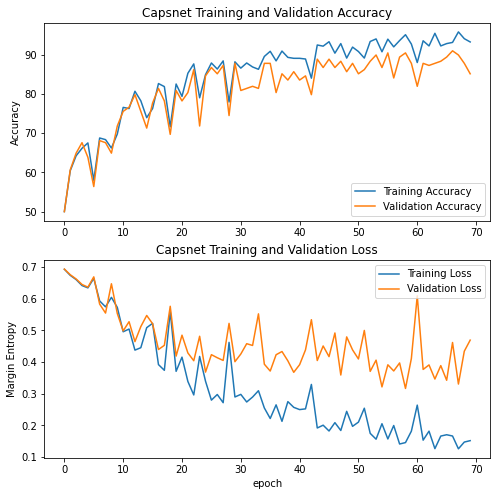

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')


def train(epoch, dataloder):
    model.train()

    t0 = time.time()
    for (X_batch, y_batch) in tqdm(dataloder, leave=False, desc=f'epoch:{epoch}'):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        out_put = model(X_batch)
        loss = loss_fn(out_put, y_batch)
        loss.backward()
        optimizer.step()
    now_lr = optimizer.param_groups[0]["lr"]
#     scheduler.step()
    t1 = time.time()
    print(f'epoch[{epoch}] time[{round(t1 - t0, 1)}]s lr:{now_lr}')
    return now_lr

def evaluate(data_loader, type):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        eval_loss = 0
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(F.softmax(outputs, dim=-1), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            eval_loss += loss_fn(outputs, labels).item()
    acc = 100 * correct / total
    print(f'Accuracy on {type} set: {round(acc, 2)}%  eval_loss:{eval_loss / total}')
    return acc, eval_loss / total


'''
每次运行之后要保存：
1.模型本身
2.模型迭代次数
3.模型学习率
4.历代模型表现情况loss,acc等

'''


if __name__ == '__main__':
    weight_path_best = os.path.join(result_path, 'best')
    if not os.path.exists(weight_path_best):
        os.mkdir(weight_path_best)
    for epoch in range(last_epoch, num_epoch):
        weight_name = '{}-oral'.format(model_name)
        lr = train(epoch, train_loader)
        train_acc, train_loss = evaluate(train_loader, type='train')
        test_acc, test_loss = evaluate(test_loader, type='test')
        
        # 保存训练好的模型之前，删掉已有的模型
        for f in glob.glob(result_path + '/**.pth'):
            os.remove(f)
        weight_name = weight_name + '_epoch{}.pth'.format(epoch + 1)
        weight_path = os.path.join(result_path, weight_name)
        torch.save(model, weight_path)
        
        if test_acc > test_acc_best:
            test_acc_best = test_acc
            for f in glob.glob(weight_path_best + '/**.pth'):
                os.remove(f)
            torch.save(model, os.path.join(weight_path_best, weight_name))
        train_test_data.loc[len(train_test_data.index)] = [train_acc, train_loss,
                                                           lr,
                                                           test_acc, test_loss,
                                                           epoch, test_acc_best]

        train_test_data.to_csv(train_test_data_path, index=False)

    train_acc_array = train_test_data['train_acc'].values
    test_acc_array = train_test_data['test_acc'].values
    train_loss_array = train_test_data['train_loss'].values
    test_loss_array = train_test_data['test_loss'].values

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(train_acc_array, label='Training Accuracy')
    plt.plot(test_acc_array, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Capsnet Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(train_loss_array, label='Training Loss')
    plt.plot(test_loss_array, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Margin Entropy')
    plt.title('Capsnet Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [11]:
!zip -q -r output.zip /kaggle/working/check_point 

import os
os.chdir('/kaggle/working')
from IPython.display import FileLink
FileLink('output.zip')

/kaggle/working/output.zip